In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [5]:
# Load the stock data (example: Apple stock)
df = yf.download('AAPL', start='2010-01-01', end='2023-09-30')

[*********************100%***********************]  1 of 1 completed


In [6]:
# Preprocessing the data
df = df[['Close']]  # We will use the 'Close' column for prediction

# Normalize the dataset to a range of 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

In [7]:
# Create training data
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [8]:
# Create a function to create the dataset matrix
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [9]:
# Prepare the training dataset
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [10]:
# Reshape the input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [13]:
# Build the LSTM model with Input layer
inputs = Input(shape=(time_step, 1))
x = LSTM(units=50, return_sequences=True)(inputs)
x = LSTM(units=50, return_sequences=False)(x)
x = Dense(units=25)(x)
outputs = Dense(units=1)(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=10)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0106
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 1.7441e-04
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1.1470e-04
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1.1851e-04
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 1.1602e-04
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1.1015e-04
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 1.1772e-04
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1.0694e-04
Epoch 9/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 9.4886e-05
Epoch 10/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1.0704e-04


In [14]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [15]:
# Reverse the scaling
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

In [16]:
# Visualize the results
# Shift train predictions for plotting
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict) + time_step, :] = train_predict

In [17]:
# Shift test predictions for plotting
test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(train_predict) + (time_step * 2) + 1:len(scaled_data) - 1, :] = test_predict

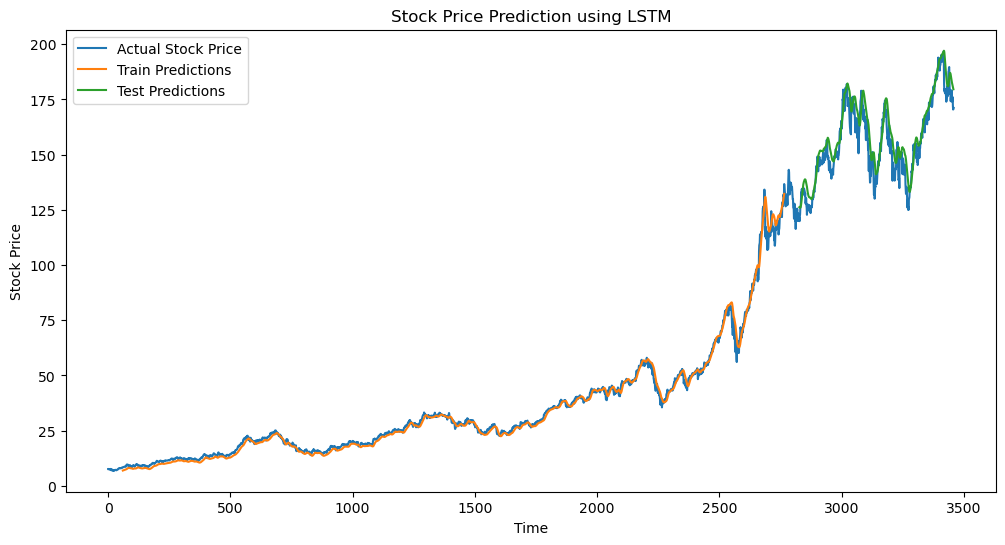

In [18]:
# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(scaled_data), label="Actual Stock Price")
plt.plot(train_plot, label="Train Predictions")
plt.plot(test_plot, label="Test Predictions")
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

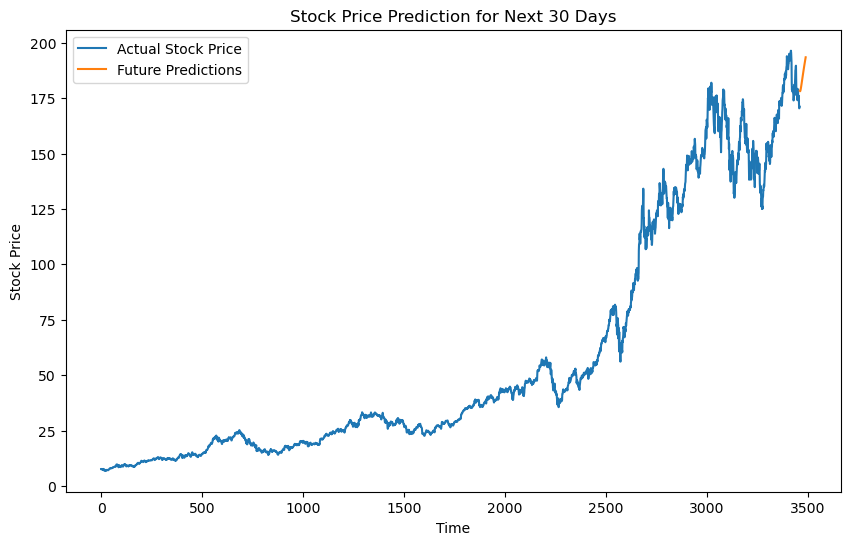

In [19]:
# Predict future stock prices (e.g., next 30 days)

# Get the last 'time_step' days of data from the test set
x_input = test_data[-time_step:].reshape(1, -1)

# Generate predictions for the next n days
n_days = 30
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

predictions = []

for i in range(n_days):
    if len(temp_input) > time_step:
        # Reshape input for LSTM model
        x_input = np.array(temp_input[-time_step:]).reshape(1, time_step, 1)
        # Predict next value
        yhat = model.predict(x_input, verbose=0)
        # Append prediction
        temp_input.append(yhat[0][0])
        predictions.append(yhat[0][0])
    else:
        x_input = np.array(temp_input).reshape(1, time_step, 1)
        yhat = model.predict(x_input, verbose=0)
        temp_input.append(yhat[0][0])
        predictions.append(yhat[0][0])

# Transform the predicted prices back to original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Plot the future predictions
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(df)), scaler.inverse_transform(scaled_data), label='Actual Stock Price')
plt.plot(np.arange(len(df), len(df) + n_days), predictions, label='Future Predictions')
plt.title('Stock Price Prediction for Next 30 Days')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()